In [8]:
# !pip install pgmpy pyAgrum daft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 50.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 85.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 47.0 MB/s eta 0:00:00


In [1]:
import sys
from os import path
sys.path.append(path.join("..", "src"))
import torch
import torchvision
from torch import nn
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, ConcatDataset, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from packages.spn.experiments.RandomSPNs_layerwise.rat_spn import RatSpn, RatSpnConfig
from packages.spn.experiments.RandomSPNs_layerwise.distributions import RatNormal
from packages.spn.algorithms.layerwise.distributions import Bernoulli, Categorical
from constraint.constraints import *
import time
import argparse
from tqdm import tqdm
from pathlib import Path

<Axes: >

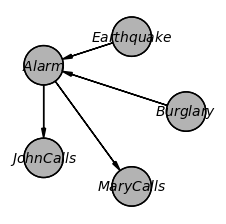

In [2]:
from pgmpy.readwrite import BIFReader
name = "earthquake"
bn = BIFReader(f"{name}.bif").get_model()
bn.to_daft().render()

In [3]:
bn.simulate(n_samples=100)

  0%|          | 0/5 [00:00<?, ?it/s]

/home/ubuntu/miniconda3/lib/python3.11/site-packages/pgmpy/sampling/base.py:582: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)


,JohnCalls,MaryCalls,Alarm,Earthquake,Burglary
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
95,0,0,0,0,0
96,0,0,0,0,0
97,0,0,0,0,0
98,0,0,0,0,0


In [4]:
def get_cis(bn):
    return [
        (list(indep.event1)[0], each, list(indep.event3)[0])
        
        for indep in bn.get_independencies().get_assertions()
        for each in indep.event2
        if len(indep.event3)==1
    ]
import random
cis = random.sample(get_cis(bn), 10)

In [5]:
train = bn.simulate(n_samples=100, seed=0).astype(int) # sample_from_bn("sachs", 100)
# train.replace({"LOW": 0, "AVG": 1, "HIGH": 2}, inplace=True)

test = bn.simulate(n_samples=100, seed=1).astype(int) # sample_from_bn("sachs", 100)
# test.replace({"LOW": 0, "AVG": 1, "HIGH": 2}, inplace=True)

  0%|          | 0/5 [00:00<?, ?it/s]

/home/ubuntu/miniconda3/lib/python3.11/site-packages/pgmpy/sampling/base.py:582: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)


  0%|          | 0/5 [00:00<?, ?it/s]

/home/ubuntu/miniconda3/lib/python3.11/site-packages/pgmpy/sampling/base.py:582: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)


In [6]:
use_cuda=True
kwargs = {"num_workers": 8, "pin_memory": True} if use_cuda else {}
batch_size = 64
test_batch_size = batch_size


train_dataset, test_dataset = TensorDataset(torch.Tensor(train.to_numpy())), TensorDataset(torch.Tensor(test.to_numpy()))
# Train data loader
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    **kwargs,
)

# Test data loader
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False,
    **kwargs,
)
names = train.columns.tolist()

In [7]:
def make_spn(S, I, R, D, F, C, device, leaf_base_class, leaf_base_kwargs=None) -> RatSpn:
        """Construct the RatSpn"""

        # Setup RatSpnConfig
        config = RatSpnConfig()
        config.F = F
        config.R = R
        config.D = D
        config.I = I
        config.S = S
        config.C = C
        config.dropout = 0.0
        config.leaf_base_class = leaf_base_class 
        config.leaf_base_kwargs = {} if leaf_base_kwargs is None else leaf_base_kwargs

        # Construct RatSpn from config
        model = RatSpn(config)

        model = model.to(device)
        model.train()

        print("Using device:", device)
        return model


rat_S, rat_I, rat_D, rat_R, rat_C, leaves = 20, 20, 2, 5, 1,Categorical #RatNormal
n_features = train_loader.dataset[0][0].shape[0]
r = [bn.get_cardinality(each) for each in test.columns]
device=torch.device("cuda")
dropout=0
model = make_spn(S=rat_S, I=rat_I, D=rat_D, R=rat_R, device=device, F=n_features, C=rat_C,leaf_base_class=leaves, leaf_base_kwargs=dict(num_bins=max(r)))

Using device: cuda


In [28]:
def train(model, train_loader, constraints, n_iterations=1000, t_max=0, tol=1e-4, device='cpu'):
    
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    prev_loss, total_loss = 0, 0
    rel_change_loss, rel_change_penalty = 0, 0
    prev_penalty, total_penalty = 0, 0
    config_data = {}
    prev_loss = 0
    for t in range(-1, t_max):    
        total_data_loss, total_penalty = 0, 0
        for iteration in range(n_iterations):
            total_loss = 0
            for (data,) in tqdm(train_loader, total = len(train_loader)):
                data = data.to(device)
                optimizer.zero_grad()
                outputs = model(data)
                loss = -outputs.sum() / data.shape[0]
                total_data_loss += loss
                
                penalty = torch.tensor(0.0, device=device)
                for constraint in constraints:
                    penalty += constraint.violation(model, train_loader.dataset, config_data, device=device, batch_size=64)
                
                total_penalty += penalty
                if t >= 0:
                    lambda_ = 10**t
                    loss += lambda_*penalty
                total_loss += loss
                loss.backward()
                optimizer.step()
            
            
            if iteration > 0:
                rel_change_loss = (prev_loss - total_loss) / prev_loss
            if iteration >0 and rel_change_loss < tol:
                break
            prev_loss = total_loss
        
        if t >= 0 and total_penalty/(iteration+1) < tol:
            break
        print (f"{iteration} {t} {total_data_loss/(iteration+1):.4f} {rel_change_loss} {total_penalty/(iteration+1)}")
        """
        if iteration > 0: 
            rel_change_loss = (prev_loss - total_loss) / prev_loss
            rel_change_penalty = (prev_penalty - total_penalty) / prev_penalty
            if rel_change_loss < tol or iteration % n_iterations == 0:
                if total_penalty < tol or t == t_max:
                    break
                else:
                    t = min(t + 1, t_max)                    
                    
                
            if iteration % 10 == 1:
                print (f"{t} {total_loss:.4f}, {rel_change_loss:.4f}, {total_penalty:.4f}, {rel_change_penalty:.4f}")
        prev_loss = total_loss 
        prev_penalty = total_penalty
        """
    # print (f"{t} {total_loss:.4f}, {rel_change_loss:.4f}, {total_penalty:.4f}, {rel_change_penalty:.4f}")
    return model
            

In [29]:

"""
class ContextSpecificIndependence(EqualityConstraint):
    def __init__(self, X, Y, Z, z, r):
        # X \indep Y | Z = z
        self.X = X
        self.Y = Y
        self.Z = Z
        self.z = z
        self.r = r
        super().__init__()
    
    def violation(self, model, dataset, config_data, device="cpu", **kwargs):
        # P(X | Y, Z = z) = P(X | Z = z) 
        n_features = len(self.r)
        data = torch.zeros((self.r[self.Y], n_features), device=device)
        for i in range(self.r[self.Y]):
            data[i, self.Y] = i
            data[i, self.Z] = self.z
        
        marg_indices = [i for i in range(n_features) if i not in (self.X, self.Y, self.Z )]
        p1 = predict_proba(model, self.r, data, self.X, marg_indices, device)
        p2 = predict_proba(model, self.r, data, self.X, marg_indices + [self.Y], device)
        delta = self.delta(p1.ravel(), p2.ravel())
        violation = self.degree_violation(delta)
        return violation / (self.r[self.X]*self.r[self.Y])
"""        
constraints = [
    ContextSpecificIndependence(names.index(X), names.index(Y), names.index(Z), z, r)
    for X, Y, Z in cis[0:1]
    for z in range(r[names.index(Z)])
] + [
    ContextSpecificIndependence(names.index(Y), names.index(X), names.index(Z), z, r)
    for X, Y, Z in cis[0:1]
    for z in range(r[names.index(Z)])
]


model = make_spn(S=rat_S, I=rat_I, D=rat_D, R=rat_R, device=device, F=n_features, C=rat_C,leaf_base_class=leaves, leaf_base_kwargs=dict(num_bins=max(r)))
model = train(model, train_loader, constraints, t_max=0, tol=1e-16,device=device)

Using device: cuda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  5.91it/s]

37 -1 4.4479 -0.012635331600904465 0.02144527994096279


In [30]:
log_likelihood(test_loader, model, device)

-144.79891967773438

In [31]:
model = train(model, train_loader, constraints, t_max=10+1, device=device, tol=1e-16)

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  6.10it/s]


1 -1 2.5234 -0.006875011138617992 0.05394047126173973


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  5.31it/s]


5 0 2.2483 -0.0050463383086025715 0.05094330012798309


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  5.33it/s]


5 1 1.9478 -0.02415626496076584 0.023432767018675804


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  5.33it/s]


4 2 1.7611 -0.06457554548978806 0.0035997626837342978


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  5.33it/s]


1 3 1.7756 -0.04760900139808655 0.002287347801029682


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  5.05it/s]


2 4 1.7531 -0.3803307116031647 0.0030766658019274473


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  5.24it/s]


1 5 1.6648 -0.5304370522499084 0.001213432289659977


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  5.33it/s]


2 6 1.7355 -1.4433180093765259 0.0028522580396384


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  5.34it/s]


1 7 1.7623 -0.7445425391197205 0.0034390846267342567


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  5.33it/s]


1 8 1.6888 -1.1011296510696411 0.0024252403527498245


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  5.34it/s]


1 9 1.7091 -0.06949002295732498 0.0027409102767705917


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  5.35it/s]

8 10 1.6936 -1.3303232192993164 0.0008446257561445236


In [32]:
log_likelihood(test_loader, model, device)

-107.48369979858398